# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [79]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


RObject{StrSxp}
[1] "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"
[2] "C:/Users/User/AppData/Local/R/win-library/4.3"                                                                      
[3] "C:/Program Files/R/R-4.3.1/library"                                                                                 


## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

In [124]:
include(joinpath(project_root, "src", "Julia", "utils", "simulation.jl"))


simulation_name = "3_predictors"
simulation_settings_file = "default"

params_train = (
    observations = 500,
    measurements = 50,
    basis_functions = 5,
    error_sd = 0,
    seed = 1
)

params_test = (
    observations = 250,
    measurements = 50,
    basis_functions = 5,
    error_sd = 0,
    seed = 1
)

output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)




OrderedCollections.OrderedDict{Symbol, Any} with 24 entries:
  :predictors        => 3.0
  :measurements      => 500.0
  :observations      => 500.0
  :basis_functions   => 5.0
  :intercept         => 0.0
  :norder            => 4.0
  :error_sd          => 0.05
  :seed              => 1.0
  :noise_sd          => 0.0
  :mu_funcs          => Any[RFunction{RObject{ClosSxp}}(RObject{ClosSxp}…
  :cov_funcs         => Any[OrderedDict{Symbol, Any}(:sig2=>0.2, :rho=>0.11, :d…
  :beta_funcs        => Any[RFunction{RObject{ClosSxp}}(RObject{ClosSxp}…
  :time_domains      => Any[[0.0, 0.00200401, 0.00400802, 0.00601202, 0.0080160…
  :true_predictors   => [1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
  :param_name        => 5
  :X                 => [-0.521447 -0.112196 4.88008; -0.424444 0.737434 4.2201…
  :Y                 => [2.30166, 1.67957, 2.28597, 2.23536, 2.08099, 2.25094, …
  :Z                 => [0.0194444 0.104649 -0.0184236; 0.00749755 0.161046 0.0…
  :J                 => [0.0714286 0.0437502 … 0

In [107]:

# Grab the outputs from the R script

predictors = output[:predictors]
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = output[:observations]

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W];

Y_test = output_test[:Y]
Z_test = output_test[:X]


500×3×500 Array{Float64, 3}:
[:, :, 1] =
 -0.521447   -0.112196    4.88008
 -0.424444    0.737434    4.22015
  0.458564   -0.151244    4.39829
 -0.125526    0.818474    3.75333
 -0.619892   -0.00191181  4.91518
  0.393742   -0.40074     4.95779
  0.342136   -0.0191333   3.90711
  0.476195    0.875752    3.99129
  0.185194   -0.00789593  4.39765
  0.305412    0.320544    3.67262
 -0.167542    0.00332671  3.77252
  0.0528501  -0.553435    2.90753
 -0.149049    0.723297    3.94024
  ⋮                       
 -0.947127    0.318652    4.54826
  0.487042   -0.365096    4.95783
  0.624158   -0.159459    3.88949
  0.205605    0.108343    4.99829
 -0.607911    0.946993    5.75848
 -0.527288   -0.846081    4.64067
  0.655393    0.823696    2.8897
  0.0155382  -0.223814    3.39274
  0.207874   -0.357667    4.44346
 -0.184892    0.496846    2.9731
 -0.538119    0.279037    4.03236
 -0.452201   -0.112477    4.68447

[:, :, 2] =
 -0.524647   -0.098333    4.87177
 -0.40723     0.747847    4.19063
  0

### Let's plot the data

The `plot_predictor_observations` function is used to plot the functional data for a specified predictor across multiple observations. It starts by plotting the first observation and then iteratively adds the remaining observations to the same plot. This function is useful for visualizing how a predictor behaves across different samples.
The `plot_transformed_W` function plots the matrix `W` after transforming it with the corresponding basis values. This is done for a specific predictor across multiple observations. The transformation involves a matrix multiplication of the basis values with the `W` matrix for each observation, which is then plotted. This visualization helps in understanding the effect of the basis transformation on the weights `W`.
Finally, the `plot_Z_observations` function plots the observations from the `Z` matrix for a given predictor. This is similar to the first function but applies to the `Z` matrix, which often contains the true or observed values before any transformation or modeling is applied.



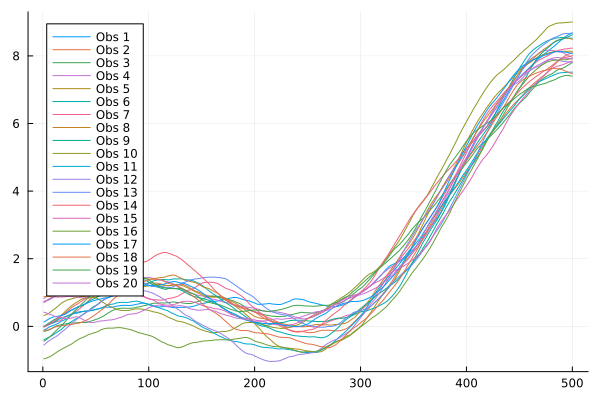

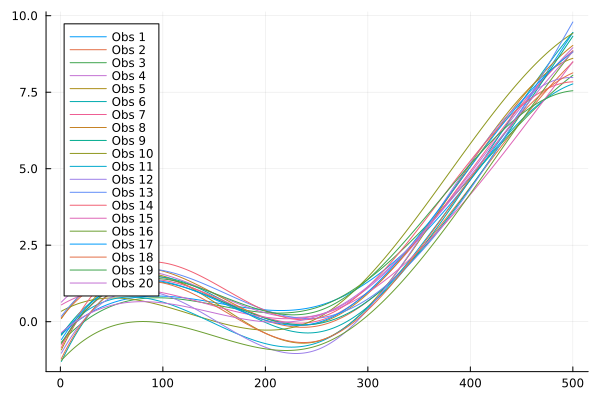

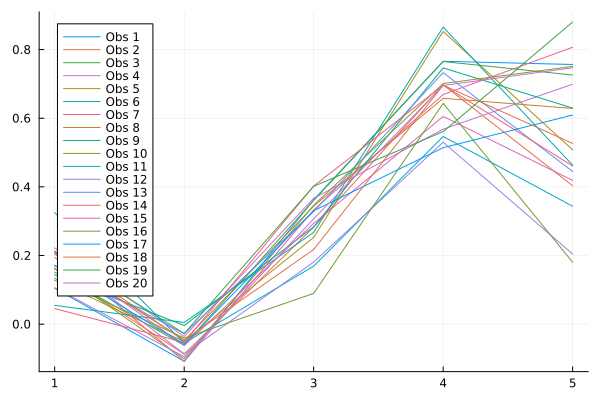

In [108]:
using Plots

# Function to plot multiple observations for a single predictor
function plot_predictor_observations(X, predictor, obs)
    p = plot(X[1, predictor, :], label = "Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p, X[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot the W matrix transformed by the basis values
function plot_transformed_W(basis_values, W, predictor, obs)
    p = plot(basis_values[predictor,:,:] * W[1, predictor, :], label = "Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p, basis_values[predictor,:,:] * W[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot Z for multiple observations
function plot_Z_observations(Z, predictor, obs)
    p = plot(Z[1, predictor, :], label = "Obs 1")  # Start with the first observation
    for i in 2:obs
        plot!(p, Z[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Initialize the plot for predictors
predictor = 2
obs = 20  # Limiting to the first 20 observations for clarity

# Plot the predictor for the first 20 observations
p1 = plot_predictor_observations(X, predictor, obs)
display(p1)

# Plot the transformed W using the corresponding basis values for the first 20 observations
p2 = plot_transformed_W(basis_values, W, predictor, obs)
display(p2)

# Plot Z for the first 20 observations
p3 = plot_Z_observations(Z, predictor, obs)
display(p3)


## Plotting the Y, Z, W, Basis
Visualize the processed input data to understand its distribution and structure before running the model.

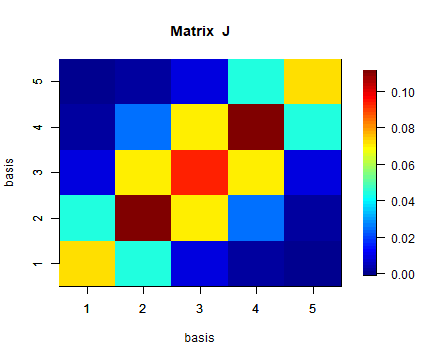

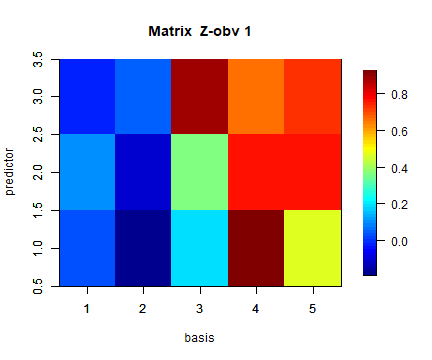

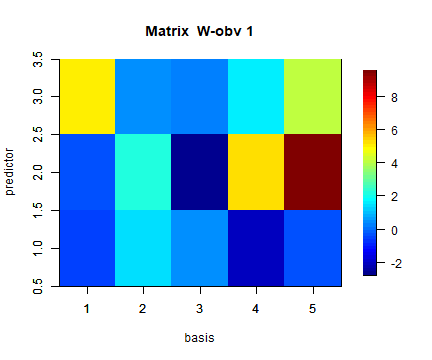

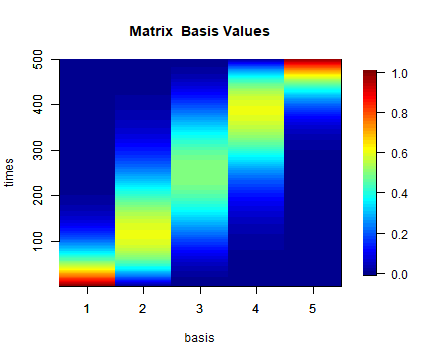

RObject{RealSxp}
[1] 1 2 3 4 5


In [109]:
using RCall

@rput J Z W basis_values
R"""
source(here("src", "R", "generic_simulator", "utils", "plot_utilities.R"))

plot_design_matrix(J[1,,], "J", "basis","basis")
#loop over the rows of Z in R code
for( i in 1:1 ) {
    plot_design_matrix(Z[i, ,], paste("Z-obv",i),"basis", "predictor")
    plot_design_matrix(W[i, ,], paste("W-obv",i),"basis", "predictor")
}
plot_design_matrix(basis_values[1,,], "Basis Values", "basis","times")

"""

## Model Execution
Run the predictive model using the prepared data.

In [110]:
model_name = "l0_and_limit.jl"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name)

include(model_file_path)

λ =0.01
λ_group = 0.001
M = 100

to_predict = sum(true_predictors)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, λ, λ_group, M, to_predict)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 60
Set parameter Presolve to value 2
Set parameter Heuristics to value 0.5
Set parameter MIPGap to value 0.05
Set parameter Threads to value 1
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 1
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 0.01
Set parameter IntFeasTol to value 1e-06
Set parameter Threads to value 1
Set parameter TimeLimit to value 60
Set parameter NumericFocus to value 1
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter MIPGap to value 0.05
Set parameter OptimalityTol to value 0.01
Set parameter IntFeasTol to value 1e-06
Set parameter NonConvex to value 2
Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 log

([0.857960487776391 1.1076992968001598 … 0.6907070871590744 0.5423733784368099; 0.0 0.0 … 0.7800063266389347 0.8561945280378591; 0.0 0.0 … 0.0 0.0], 0.0, [1, 1, 0])

## Model Results
Display the results of the model, including the estimated beta coefficients.

In [111]:
beta_matrix # true beta

3×5 Matrix{Float64}:
  0.999923    1.00035  0.914664  0.680777  0.540256
 -7.09664e-6  0.17459  0.523199  0.7791    0.865948
  0.0         0.0      0.0       0.0       0.0

In [112]:
beta_star  # estimated beta

3×5 Matrix{Float64}:
 0.85796  1.1077  0.89908   0.690707  0.542373
 0.0      0.0     0.565148  0.780006  0.856195
 0.0      0.0     0.0       0.0       0.0

## Data Comparison
Compare the true beta matrix with the estimated beta matrix and calculate the percentage difference for each coefficient.

In [113]:
using DataFrames

# Ensure beta_matrix and beta_star have the same dimensions
if size(beta_matrix) != size(beta_star)
    error("beta_matrix and beta_star must have the same dimensions")
end

# Create a DataFrame and calculate the percentage error for each coefficient
df = DataFrame()
for i in 1:size(beta_matrix, 2)
    percent_error_col = Symbol("%_err_$i")

    # Replace values less than 10^-6 with zero in beta_matrix and beta_star
    beta_matrix[:, i] = ifelse.(abs.(beta_matrix[:, i]) .< 1e-6, 0, beta_matrix[:, i])
    beta_star[:, i] = ifelse.(abs.(beta_star[:, i]) .< 1e-6, 0, beta_star[:, i])

    # Calculate the percentage error while handling division by zero
    percent_error = ifelse.(beta_matrix[:, i] .== 0,
        ifelse.(beta_star[:, i] .== 0, 0, 100),
        round.(((beta_star[:, i] .- beta_matrix[:, i]) ./ beta_matrix[:, i]) .* 100, digits = 2)
    )
    # Convert the percentage error to a string with the percentage symbol, cap values over 500%
    df[!, percent_error_col] = ifelse.(percent_error .> 500.0, " >  500 %", string.(percent_error, " %"))
    df[!, percent_error_col] = ifelse.(percent_error .< -500.0, "< 500 %", df[!, percent_error_col])

end

# Show the DataFrame
display(df)

Row,%_err_1,%_err_2,%_err_3,%_err_4,%_err_5
,String,String,String,String,String
1,-14.2 %,10.73 %,-1.7 %,1.46 %,0.39 %
2,-100.0 %,-100.0 %,8.02 %,0.12 %,-1.13 %
3,0 %,0 %,0 %,0 %,0 %


## Evaluate Model Performance
Evaluate the model's performance using various metrics such as MSE, RMSE, MAE, and relative error.

In [114]:
using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix, beta_star, alpha_star, groups, true_predictors)



Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.160834
  "CDF_Distance"           => 58.3755
  "R_squared"              => -63.3476
  "RMSE_Predictions"       => 2.7541
  "RMSE_Coefficients"      => 0.065503
  "Area_Between_Curves"    => 1143.34
  "ISE_Coefficients"       => 0.0643597
  "MSE_Predictions"        => 7.58509
  "Adjusted_R_squared"     => -64.0005
  "MSE_Coefficients"       => 0.00429065
  "MAE_Predictions"        => 2.28668

## Prediction and Evaluation
Make predictions using the estimated coefficients and evaluate the model's accuracy.

In [115]:
using Statistics

# Evaluation of all metrics in the performance dictionary
function evaluate_all_metrics(performances, thresholds, higher_is_better)
    evaluations = Dict{String, String}()
    for (generic_name, metric_value) in performances
        if haskey(thresholds, generic_name)
            good_threshold, excellent_threshold = thresholds[generic_name]
            is_higher_better = get(higher_is_better, generic_name, false)
            evaluations[generic_name] = valuate_metric(metric_value, good_threshold, excellent_threshold, is_higher_better)
        end
    end
    return evaluations
end

# Method to evaluate a single metric
function valuate_metric(metric_value, good_threshold, excellent_threshold=nothing, higher_is_better=false)
    if isnothing(excellent_threshold)
        # Only a good threshold is provided
        if higher_is_better
            return metric_value >= good_threshold ? "Good" : "Poor"
        else
            return metric_value <= good_threshold ? "Good" : "Poor"
        end
    else
        # Both good and excellent thresholds are provided
        if higher_is_better
            if metric_value >= excellent_threshold
                return "Excellent"
            elseif metric_value >= good_threshold
                return "Good"
            else
                return "Poor"
            end
        else
            if metric_value <= excellent_threshold
                return "Excellent"
            elseif metric_value <= good_threshold
                return "Good"
            else
                return "Poor"
            end
        end
    end
end


# Define if higher values are better for each metric
higher_is_better = Dict(
    "MSE_Coefficients"       => false,
    "RMSE_Coefficients"      => false,
    "ISE_Coefficients"       => false,
    "MSE_Predictions"        => false,
    "RMSE_Predictions"       => false,
    "MAE_Predictions"        => false,
    "R_squared"              => true,
    "Adjusted_R_squared"     => true,
    "Functional_Correlation" => true,
    "CDF_Distance"           => false,
    "Area_Between_Curves"    => false
);




In [116]:
# Compute descriptive statistics for an array
function compute_stats(data)
    return Dict(
        "mean" => mean(data),
        "std" => std(data),
        "min" => minimum(data),
        "max" => maximum(data),
        "iqr" => quantile(data, 0.75) - quantile(data, 0.25)
    )
end

# Determine scaling thresholds based on the computed statistics
function determine_scaling_thresholds(beta_stats, prediction_stats)
    # Error-based metrics: Set thresholds based on standard deviation or IQR
    scaling_thresholds = Dict(
        "MSE_Coefficients" => (beta_stats["std"], beta_stats["std"] / 2),
        "RMSE_Coefficients" => (sqrt(beta_stats["std"]), sqrt(beta_stats["std"] / 2)),
        "ISE_Coefficients" => (beta_stats["iqr"], beta_stats["iqr"] / 2),
        "MSE_Predictions" => (prediction_stats["std"], prediction_stats["std"] / 2),
        "RMSE_Predictions" => (sqrt(prediction_stats["std"]), sqrt(prediction_stats["std"] / 2)),
        "MAE_Predictions" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),
        "R_squared" => (0.5, 0.7),  # Static thresholds
        "Adjusted_R_squared" => (0.5, 0.7),  # Static thresholds
        "Functional_Correlation" => (0.3, 0.5),  # Example thresholds, adjust based on domain knowledge
        "CDF_Distance" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),  # Example, adjust as needed
        "Area_Between_Curves" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2)  # Example, adjust as needed
    )
    return scaling_thresholds
end

# Assuming you have computed your beta_matrix, beta_star, and predictions
# Compute stats for beta coefficients and predictions
beta_stats = compute_stats(reshape(beta_matrix, :))
prediction_stats = compute_stats(reshape(Y_test, :))  # Assuming Y_test contains predictions

# Determine scaling thresholds
scaling_thresholds = determine_scaling_thresholds(beta_stats, prediction_stats)

# Print thresholds
print("Scaling Thresholds: ", scaling_thresholds)


Scaling Thresholds: Dict("Functional_Correlation" => (0.3, 0.5), "CDF_Distance" => (0.44936602898628486, 0.22468301449314243), "R_squared" => (0.5, 0.7), "RMSE_Predictions" => (0.5862385313257333, 0.41453324089326826), "RMSE_Coefficients" => (0.6471308113079693, 0.4575905849906172), "Area_Between_Curves" => (0.44936602898628486, 0.22468301449314243), "ISE_Coefficients" => (0.8225241404917666, 0.4112620702458833), "MSE_Predictions" => (0.3436756156109528, 0.1718378078054764), "Adjusted_R_squared" => (0.5, 0.7), "MSE_Coefficients" => (0.41877828694411057, 0.20938914347205528), "MAE_Predictions" => (0.44936602898628486, 0.22468301449314243))

In [117]:
# Perform evaluations
evaluations = evaluate_all_metrics(performance_metrics, scaling_thresholds, higher_is_better)

# Display evaluations
for (metric, evaluation) in evaluations
    metric_value = performance_metrics[metric]
    metric_range = scaling_thresholds[metric]
    println("$metric: $evaluation, Value: $metric_value, Range: $metric_range")
end

Functional_Correlation: Poor, Value: 0.16083439685736778, Range: (0.3, 0.5)
CDF_Distance: Poor, Value: 58.37549484987653, Range: (0.44936602898628486, 0.22468301449314243)
RMSE_Predictions: Poor, Value: 2.754103741536052, Range: (0.5862385313257333, 0.41453324089326826)
RMSE_Coefficients: Excellent, Value: 0.06550304407274848, Range: (0.6471308113079693, 0.4575905849906172)
Area_Between_Curves: Poor, Value: 1143.3385027811105, Range: (0.44936602898628486, 0.22468301449314243)
ISE_Coefficients: Excellent, Value: 0.06435973174194645, Range: (0.8225241404917666, 0.4112620702458833)
Adjusted_R_squared: Poor, Value: -64.00051210761976, Range: (0.5, 0.7)
MAE_Predictions: Poor, Value: 2.286677005562221, Range: (0.44936602898628486, 0.22468301449314243)
R_squared: Poor, Value: -63.34763809996056, Range: (0.5, 0.7)
MSE_Predictions: Poor, Value: 7.585087419142879, Range: (0.3436756156109528, 0.1718378078054764)
MSE_Coefficients: Excellent, Value: 0.00429064878279643, Range: (0.41877828694411057,

## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

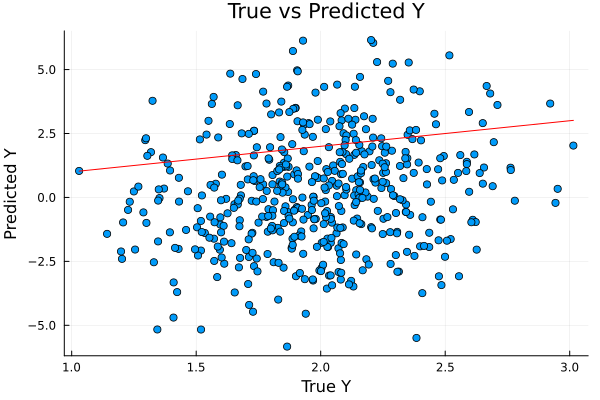

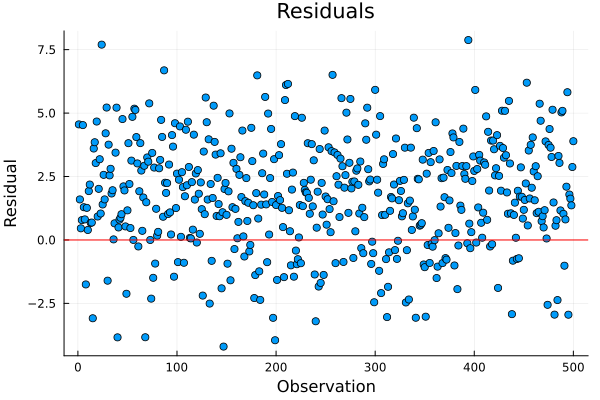

In [118]:
using Plots

Y_pred = get_predictions(Z_test, beta_star, alpha_star)
# 1. Scatter plot comparing true vs predicted values
scatter(Y_test, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y_test, Y_test, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y_test - Y_pred
scatter(1:observations, residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


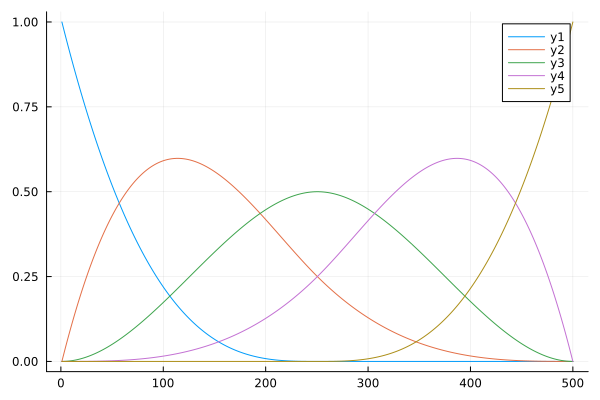

In [119]:
pbasis_values =basis_values
plot( pbasis_values[1,:,1])
plot!(pbasis_values[1,:,2])
plot!(pbasis_values[1,:,3])
plot!(pbasis_values[1,:,4])
plot!(pbasis_values[1,:,5])


## Final Output
Plot the combined predicted curve and save the output for further analysis.

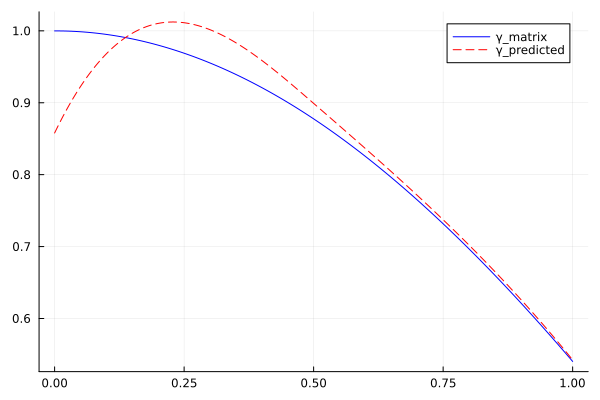

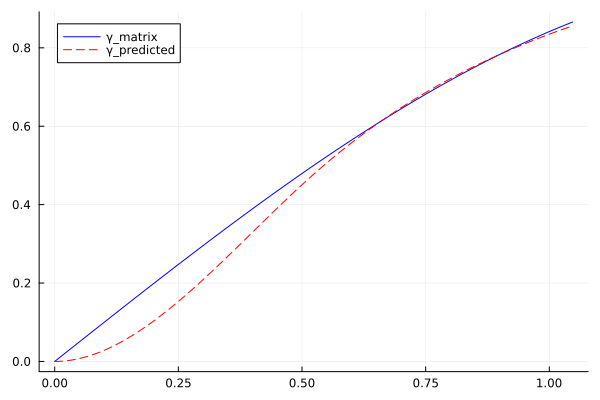

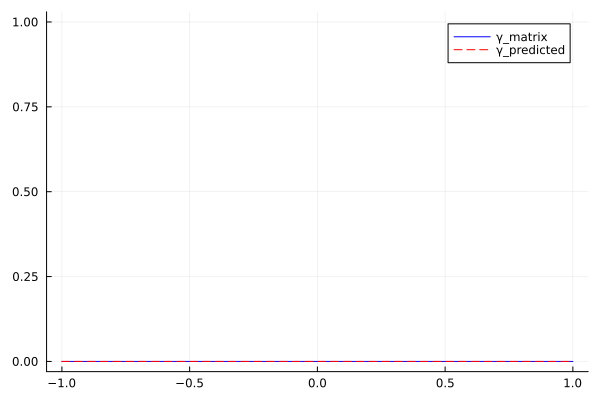

In [120]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

plot_combined_predicted_curve(beta_matrix, beta_star,basis_values, time_domains,output_folder, true)


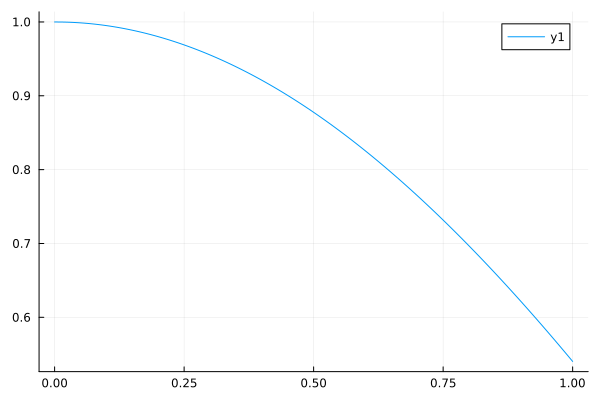

In [121]:
y =basis_values[1,:,:] * beta_matrix[1,:];
function evenly_spaced(a, b, n)
    h = (b-a)/(n-1)
    collect(a:h:b)
end

x= evenly_spaced(0, 1, 500)

plot(x,y)